# Problem 1. IMBA-SHAP: Spam Detection (40 pts)

In this problem, you will revisit the spam detection problem. This time, you will tackle this as an imbalanced ML problem--employing the concepts you've learned in working with imbalanced datasets. Read and execute carefully the instructions provided. The first part of exploring the data has already been done for you. 

<div class="alert alert-info">
    
**Important Notes**

You are already given the following:
    
`X` : **bag of words (features)**</br>
`y` : **target/indicator of Spam (1 - spam, 0 - ham)**
</div>

## Context

After estabilishing Mr. Peter Wayne's spider web inspired building, his business is up and running. However, recently, he was bombarded with spam emails and he badly needs your help again!

His company reported that there has been a proliferation of spam messages in their communications platform. His employees  is complaining of the flooding of spam messages, often resulting to cluttering of one's inbox. Mr. Wayne then decides to take a less tolerant approach in detecting spam messages. Keeping this in mind, *decide which metric is most suitable in designing your spam detector. And be prepared to justify that in your dealings with Mr. Wayne.*

Mr. Wayne stated that he will be happy to initially deploy a detector with an $80\%$ performance on the correct metric. However, he doesn't prefer Naive Bayes models due to their apparent simplicity. Beat the $80\%$ performance baseline in predicting on the **20% holdout set** using any of the ML techniques you've learned up to this point.

## Tasks

1. Choose and justify the appropriate metric for this use case. [5 pts]  

2. Beat the 80% performance baseline set by the client in predicting on the holdout set using any of the ML techniques you've learned up to this point AND WITHOUT using naive-bayes. [10 pts]  

3. Use SHAP and/or LIME to interpret the results of the best model. [10 pts]  

4. Pitch your proposed system to Mr. Wayne by responding to the following questions.   
    A. Would you even consider to use Naive Bayes models? Is the Naive Bayes models worth defending? Explain your answer. [5 pts];   
    B. Explain your choice of the best model and other interesting insights you found during your model development.[10 pts]

## Data Preprocessing and Initial EDA

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

import time
from tqdm import tqdm
from pandas.api.types import is_numeric_dtype
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, average_precision_score, auc, f1_score
import shap

# not advisable, but we do it for a cleaner report
# warnings regarding non-convergence of some classifiers used are muted
import warnings 
warnings.filterwarnings("ignore")

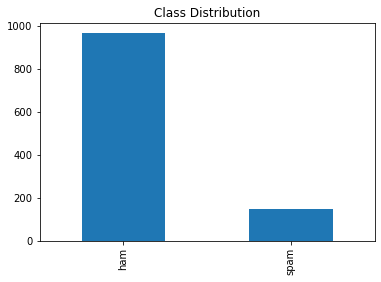

ham     0.866128
spam    0.133872
Name: class, dtype: float64


,class,text
0,ham,hope good week checking
1,ham,nice wait texting right gonna pay ticket ya know
2,ham,okie
3,ham,yeah quite bit left swing tomorrow get
4,ham,number


In [2]:
# Pre-processing already done (e.g. remove punctuations, stopwords, etc.)
df = pd.read_csv('spam.csv', encoding='utf-8')
df = df.dropna()

# Check class distribution
df['class'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.show()
print(df['class'].value_counts(normalize=True))

# Check data
df.head()

In [5]:
df.shape

(1113, 2)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

# Only use top 1000 features, can treat as a hyperparameter in general
vectorizer = CountVectorizer(max_features=1000)

# Design matrix
X = vectorizer.fit_transform(df['text']).toarray()

# Class labels: 0 for ham, 1 for spam
y = pd.get_dummies(df['class'])['spam'].to_numpy() 

In [4]:
pcc = 1.25*sum(df['class'].value_counts(normalize=True)**2)
print("1.25*PCC: %.2f" % pcc)

1.25*PCC: 0.96


In [13]:
from sklearn.model_selection import train_test_split
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, # edit X here to include X_scaled in base case
                                           random_state=11, test_size=0.20, 
                                           stratify=y)

In [24]:
def get_resampling_report(technique, scaler, metric):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import seaborn as sns
    %matplotlib inline

    import time
    from tqdm import tqdm
    from pandas.api.types import is_numeric_dtype
    from sklearn.base import TransformerMixin
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import cross_validate
    from sklearn.neighbors import KNeighborsClassifier
    from collections import Counter
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
    from sklearn.preprocessing import MinMaxScaler, RobustScaler
    from sklearn.decomposition import TruncatedSVD
    from sklearn.decomposition import PCA
    from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.under_sampling import TomekLinks
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import ADASYN
    from imblearn.combine import SMOTEENN
    from imblearn.combine import SMOTETomek
    from imblearn.pipeline import Pipeline as imbpipeline
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import accuracy_score, recall_score, precision_score, average_precision_score, auc, f1_score
    import shap

    # not advisable, but we do it for a cleaner report
    # warnings regarding non-convergence of some classifiers used are muted
    import warnings 
    warnings.filterwarnings("ignore")
    
    
    ######## kNN (Tuned) ########
    pipeline_kNN = imbpipeline(steps = [['scale', scaler],
                                        ['resampling', technique],
                                        ['kNN', KNeighborsClassifier()]])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

    param_grid_kNN = {'kNN__n_neighbors': range(1, 30)}

    grid_search_kNN = GridSearchCV(estimator=pipeline_kNN, scoring=metric,
                                   cv=skf, n_jobs=3, return_train_score=True,
                                   param_grid=param_grid_kNN)
    
    # fit and predict
    grid_search_kNN.fit(X_trainval, y_trainval)
    y_preds_kNN = grid_search_kNN.predict(X_holdout)

    # holdout scores
    holdout_acc_kNN = round(accuracy_score(y_holdout, y_preds_kNN)*100, 2)
    holdout_prec_kNN = round(precision_score(y_holdout, y_preds_kNN, pos_label=1)*100, 2)
    holdout_rec_kNN = round(recall_score(y_holdout, y_preds_kNN, pos_label=1)*100, 2)
    holdout_f1_kNN = round(f1_score(y_holdout, y_preds_kNN, pos_label=1)*100, 2)
    holdout_auc_pr_kNN = round(average_precision_score(y_holdout, y_preds_kNN)*100, 2)

    holdout_dict = {
        'accuracy': holdout_acc_kNN,
        'precision': holdout_prec_kNN,
        'recall': holdout_rec_kNN,
        'f1': holdout_f1_kNN,
        'average_precision': holdout_auc_pr_kNN
    }

    # kNN total run time
    total_time_kNN = np.sum(grid_search_kNN.cv_results_['mean_fit_time']) + np.sum(grid_search_kNN.cv_results_['mean_score_time'])
    kNN_time = total_time_kNN

    df_kNN_tuned = pd.DataFrame(
    {
        metric: [round(grid_search_kNN.best_score_*100, 2)],
        'holdout_score': [holdout_dict[metric]],
        'params': [grid_search_kNN.best_params_],
        'total_run_time': [total_time_kNN]
    }, index=['kNN'])
    
    
    
    ######## Logistic Regression (Tuned) ########
    pipeline_LR = imbpipeline(steps = [['scale', scaler],
                                       ['resampling', technique],
                                       ['LR', LogisticRegression()]])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

    param_grid_LR = {'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000],
                     'LR__penalty' : ['l1', 'l2'],
                     'LR__solver' : ['liblinear']}

    grid_search_LR = GridSearchCV(estimator=pipeline_LR, scoring=metric,
                                   cv=skf,n_jobs=3,  return_train_score=True,
                                   param_grid=param_grid_LR)

    # fit and predict
    grid_search_LR.fit(X_trainval, y_trainval)
    y_preds_LR = grid_search_LR.predict(X_holdout)

    # holdout scores
    holdout_acc_LR = round(accuracy_score(y_holdout, y_preds_LR)*100, 2)
    holdout_prec_LR = round(precision_score(y_holdout, y_preds_LR, pos_label=1)*100, 2)
    holdout_rec_LR = round(recall_score(y_holdout, y_preds_LR, pos_label=1)*100, 2)
    holdout_f1_LR = round(f1_score(y_holdout, y_preds_LR, pos_label=1)*100, 2)
    holdout_auc_pr_LR = round(average_precision_score(y_holdout, y_preds_LR)*100, 2)

    holdout_dict = {
        'accuracy': holdout_acc_LR,
        'precision': holdout_prec_LR,
        'recall': holdout_rec_LR,
        'f1': holdout_f1_LR,
        'average_precision': holdout_auc_pr_LR
    }

    # LR total run time
    total_time_LR = np.sum(grid_search_LR.cv_results_['mean_fit_time']) + np.sum(grid_search_LR.cv_results_['mean_score_time'])
    LR_time = total_time_LR

    df_LR_tuned = pd.DataFrame(
    {
        metric: [round(grid_search_LR.best_score_*100, 2)],
        'holdout_score': [holdout_dict[metric]],
        'params': [grid_search_LR.best_params_],
        'total_run_time': [total_time_LR]
    }, index=['LR'])
    
    
    
#     ######## LSVM (Tuned) ########
#     pipeline_LSVM = imbpipeline(steps = [['scale', scaler],
#                                          ['resampling', technique],
#                                          ['LSVM', SVC(kernel='linear')]])

#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

#     param_grid_LSVM = {'LSVM__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]}

#     grid_search_LSVM = GridSearchCV(estimator=pipeline_LSVM, scoring=metric,
#                                    cv=skf,  return_train_score=True,
#                                    param_grid=param_grid_LSVM)

#     # fit and predict
#     grid_search_LSVM.fit(X_trainval, y_trainval)
#     y_preds_LSVM = grid_search_LSVM.predict(X_holdout)

#     # holdout scores
#     holdout_acc_LSVM = round(accuracy_score(y_holdout, y_preds_LSVM)*100, 2)
#     holdout_prec_LSVM = round(precision_score(y_holdout, y_preds_LSVM, pos_label=1)*100, 2)
#     holdout_rec_LSVM = round(recall_score(y_holdout, y_preds_LSVM, pos_label=1)*100, 2)
#     holdout_f1_LSVM = round(f1_score(y_holdout, y_preds_LSVM, pos_label=1)*100, 2)
#     holdout_auc_pr_LSVM = round(average_precision_score(y_holdout, y_preds_LSVM)*100, 2)

#     holdout_dict = {
#         'accuracy': holdout_acc_LSVM,
#         'precision': holdout_prec_LSVM,
#         'recall': holdout_rec_LSVM,
#         'f1': holdout_f1_LSVM,
#         'average_precision': holdout_auc_pr_LSVM
#     }

#     # LSVM total run time
#     total_time_LSVM = np.sum(grid_search_LSVM.cv_results_['mean_fit_time']) + np.sum(grid_search_LSVM.cv_results_['mean_score_time'])
#     LSVM_time = total_time_LSVM

#     df_LSVM_tuned = pd.DataFrame(
#     {
#         metric: [round(grid_search_LSVM.best_score_*100, 2)],
#         'holdout_score': [holdout_dict[metric]],
#         'params': [grid_search_LSVM.best_params_],
#         'total_run_time': [total_time_LSVM]
#     }, index=['LSVM'])
    
    
    
#     ######## RBFSVM (Tuned) ########
#     pipeline_RBFSVM = imbpipeline(steps = [['scale', scaler],
#                                            ['resampling', technique],
#                                            ['RBFSVM', SVC(kernel='rbf')]])

#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

#     param_grid_RBFSVM = {'RBFSVM__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]}

#     grid_search_RBFSVM = GridSearchCV(estimator=pipeline_RBFSVM, scoring=metric,
#                                    cv=skf,  return_train_score=True,
#                                    param_grid=param_grid_RBFSVM)

#     # fit and predict
#     grid_search_RBFSVM.fit(X_trainval, y_trainval)
#     y_preds_RBFSVM = grid_search_RBFSVM.predict(X_holdout)

#     # holdout scores
#     holdout_acc_RBFSVM = round(accuracy_score(y_holdout, y_preds_RBFSVM)*100, 2)
#     holdout_prec_RBFSVM = round(precision_score(y_holdout, y_preds_RBFSVM, pos_label=1)*100, 2)
#     holdout_rec_RBFSVM = round(recall_score(y_holdout, y_preds_RBFSVM, pos_label=1)*100, 2)
#     holdout_f1_RBFSVM = round(f1_score(y_holdout, y_preds_RBFSVM, pos_label=1)*100, 2)
#     holdout_auc_pr_RBFSVM = round(average_precision_score(y_holdout, y_preds_RBFSVM)*100, 2)

#     holdout_dict = {
#         'accuracy': holdout_acc_RBFSVM,
#         'precision': holdout_prec_RBFSVM,
#         'recall': holdout_rec_RBFSVM,
#         'f1': holdout_f1_RBFSVM,
#         'average_precision': holdout_auc_pr_RBFSVM
#     }

#     # RBFSVM total run time
#     total_time_RBFSVM = np.sum(grid_search_RBFSVM.cv_results_['mean_fit_time']) + np.sum(grid_search_RBFSVM.cv_results_['mean_score_time'])
#     RBFSVM_time = total_time_RBFSVM

#     df_RBFSVM_tuned = pd.DataFrame(
#     {
#         metric: [round(grid_search_RBFSVM.best_score_*100, 2)],
#         'holdout_score': [holdout_dict[metric]],
#         'params': [grid_search_RBFSVM.best_params_],
#         'total_run_time': [total_time_RBFSVM]
#     }, index=['RBFSVM'])
    
    
    
#     ######## GaussNB (Tuned) ########
#     pipeline_GaussNB = imbpipeline(steps = [['scale', scaler],
#                                             ['resampling', technique],
#                                             ['GaussNB', GaussianNB()]])

#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

#     param_grid_GaussNB = {'GaussNB__var_smoothing': np.logspace(0,-9, num=100)}

#     grid_search_GaussNB = GridSearchCV(estimator=pipeline_GaussNB, scoring=metric,
#                                    cv=skf,  return_train_score=True,
#                                    param_grid=param_grid_GaussNB)

#     # fit and predict
#     grid_search_GaussNB.fit(X_trainval, y_trainval)
#     y_preds_GaussNB = grid_search_GaussNB.predict(X_holdout)

#     # holdout scores
#     holdout_acc_GaussNB = round(accuracy_score(y_holdout, y_preds_GaussNB)*100, 2)
#     holdout_prec_GaussNB = round(precision_score(y_holdout, y_preds_GaussNB, pos_label=1)*100, 2)
#     holdout_rec_GaussNB = round(recall_score(y_holdout, y_preds_GaussNB, pos_label=1)*100, 2)
#     holdout_f1_GaussNB = round(f1_score(y_holdout, y_preds_GaussNB, pos_label=1)*100, 2)
#     holdout_auc_pr_GaussNB = round(average_precision_score(y_holdout, y_preds_GaussNB)*100, 2)

#     holdout_dict = {
#         'accuracy': holdout_acc_GaussNB,
#         'precision': holdout_prec_GaussNB,
#         'recall': holdout_rec_GaussNB,
#         'f1': holdout_f1_GaussNB,
#         'average_precision': holdout_auc_pr_GaussNB
#     }

#     # GaussNB total run time
#     total_time_GaussNB = np.sum(grid_search_GaussNB.cv_results_['mean_fit_time']) + np.sum(grid_search_GaussNB.cv_results_['mean_score_time'])
#     GaussNB_time = total_time_GaussNB

#     df_GaussNB_tuned = pd.DataFrame(
#     {
#         metric: [round(grid_search_GaussNB.best_score_*100, 2)],
#         'holdout_score': [holdout_dict[metric]],
#         'params': [grid_search_GaussNB.best_params_],
#         'total_run_time': [total_time_GaussNB]
#     }, index=['GaussNB'])
    
    
    
    ######## DT (Tuned) ########
    pipeline_DT = imbpipeline(steps = [['scale', scaler],
                                       ['resampling', technique],
                                       ['DT', DecisionTreeClassifier(random_state=11)]])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

    param_grid_DT = {'DT__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

    grid_search_DT = GridSearchCV(estimator=pipeline_DT, scoring=metric,
                                   cv=skf, n_jobs=3, return_train_score=True,
                                   param_grid=param_grid_DT)

    # fit and predict
    grid_search_DT.fit(X_trainval, y_trainval)
    y_preds_DT = grid_search_DT.predict(X_holdout)

    # holdout scores
    holdout_acc_DT = round(accuracy_score(y_holdout, y_preds_DT)*100, 2)
    holdout_prec_DT = round(precision_score(y_holdout, y_preds_DT, pos_label=1)*100, 2)
    holdout_rec_DT = round(recall_score(y_holdout, y_preds_DT, pos_label=1)*100, 2)
    holdout_f1_DT = round(f1_score(y_holdout, y_preds_DT, pos_label=1)*100, 2)
    holdout_auc_pr_DT = round(average_precision_score(y_holdout, y_preds_DT)*100, 2)

    holdout_dict = {
        'accuracy': holdout_acc_DT,
        'precision': holdout_prec_DT,
        'recall': holdout_rec_DT,
        'f1': holdout_f1_DT,
        'average_precision': holdout_auc_pr_DT
    }

    # DT total run time
    total_time_DT = np.sum(grid_search_DT.cv_results_['mean_fit_time']) + np.sum(grid_search_DT.cv_results_['mean_score_time'])
    DT_time = total_time_DT

    df_DT_tuned = pd.DataFrame(
    {
        metric: [round(grid_search_DT.best_score_*100, 2)],
        'holdout_score': [holdout_dict[metric]],
        'params': [grid_search_DT.best_params_],
        'total_run_time': [total_time_DT]
    }, index=['DT'])
    
    
    
    ######## RF (Tuned) ########    
    pipeline_RF = imbpipeline(steps = [['scale', scaler],
                                       ['resampling', technique],
                                       ['RF', RandomForestClassifier(random_state=11)]])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

    param_grid_RF = {'RF__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 
                     'RF__n_estimators': [100, 200, 300, 400, 500]}

    grid_search_RF = GridSearchCV(estimator=pipeline_RF, scoring=metric,
                                   cv=skf, n_jobs=3, return_train_score=True,
                                   param_grid=param_grid_RF)

    # fit and predict
    grid_search_RF.fit(X_trainval, y_trainval)
    y_preds_RF = grid_search_RF.predict(X_holdout)

    # holdout scores
    holdout_acc_RF = round(accuracy_score(y_holdout, y_preds_RF)*100, 2)
    holdout_prec_RF = round(precision_score(y_holdout, y_preds_RF, pos_label=1)*100, 2)
    holdout_rec_RF = round(recall_score(y_holdout, y_preds_RF, pos_label=1)*100, 2)
    holdout_f1_RF = round(f1_score(y_holdout, y_preds_RF, pos_label=1)*100, 2)
    holdout_auc_pr_RF = round(average_precision_score(y_holdout, y_preds_RF)*100, 2)

    holdout_dict = {
        'accuracy': holdout_acc_RF,
        'precision': holdout_prec_RF,
        'recall': holdout_rec_RF,
        'f1': holdout_f1_RF,
        'average_precision': holdout_auc_pr_RF
    }

    # RF total run time
    total_time_RF = np.sum(grid_search_RF.cv_results_['mean_fit_time']) + np.sum(grid_search_RF.cv_results_['mean_score_time'])
    RF_time = total_time_RF

    df_RF_tuned = pd.DataFrame(
    {
        metric: [round(grid_search_RF.best_score_*100, 2)],
        'holdout_score': [holdout_dict[metric]],
        'params': [grid_search_RF.best_params_],
        'total_run_time': [total_time_RF]
    }, index=['RF'])
    
    
    
    ######## GBM (Tuned) ########
    pipeline_GBM = imbpipeline(steps = [['scale', scaler],
                                        ['resampling', technique],
                                        ['GBM', GradientBoostingClassifier(random_state=11)]])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

    param_grid_GBM = {'GBM__max_depth': [2, 3, 4, 5, 6], 
                     'GBM__n_estimators': [100, 200, 300, 400, 500],
                     'GBM__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

    grid_search_GBM = GridSearchCV(estimator=pipeline_GBM, scoring=metric,
                                   cv=skf, n_jobs=3, return_train_score=True,
                                   param_grid=param_grid_GBM)

    # fit and predict
    grid_search_GBM.fit(X_trainval, y_trainval)
    y_preds_GBM = grid_search_GBM.predict(X_holdout)

    # holdout scores
    holdout_acc_GBM = round(accuracy_score(y_holdout, y_preds_GBM)*100, 2)
    holdout_prec_GBM = round(precision_score(y_holdout, y_preds_GBM, pos_label=1)*100, 2)
    holdout_rec_GBM = round(recall_score(y_holdout, y_preds_GBM, pos_label=1)*100, 2)
    holdout_f1_GBM = round(f1_score(y_holdout, y_preds_GBM, pos_label=1)*100, 2)
    holdout_auc_pr_GBM = round(average_precision_score(y_holdout, y_preds_GBM)*100, 2)

    holdout_dict = {
        'accuracy': holdout_acc_GBM,
        'precision': holdout_prec_GBM,
        'recall': holdout_rec_GBM,
        'f1': holdout_f1_GBM,
        'average_precision': holdout_auc_pr_GBM
    }

    # GBM total run time
    total_time_GBM = np.sum(grid_search_GBM.cv_results_['mean_fit_time']) + np.sum(grid_search_GBM.cv_results_['mean_score_time'])
    GBM_time = total_time_GBM

    df_GBM_tuned = pd.DataFrame(
    {
        metric: [round(grid_search_GBM.best_score_*100, 2)],
        'holdout_score': [holdout_dict[metric]],
        'params': [grid_search_GBM.best_params_],
        'total_run_time': [total_time_GBM]
    }, index=['GBM'])
    
    
    
    ######## Combine Results in a DataFrame ########
    # li = [df_kNN_tuned, df_LR_tuned, df_LSVM_tuned, df_RBFSVM_tuned, df_GaussNB_tuned, df_DT_tuned, df_RF_tuned, df_GBM_tuned]
    li = [df_kNN_tuned, df_LR_tuned, df_DT_tuned, df_RF_tuned, df_GBM_tuned]
    df_resampled_scores_tuned = pd.concat(li, axis=0)
    df_resampled_scores_tuned
    return df_resampled_scores_tuned

In [9]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

smote = SMOTE(random_state=11)
adasyn = ADASYN(random_state=11)
smoteenn = SMOTEENN(random_state=11)
smotetomek = SMOTETomek(random_state=11)
# random_under_sampler = RandomUnderSampler(random_state=11)
# tomek_links = TomekLinks()

In [10]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, average_precision_score, auc, f1_score

In [25]:
get_resampling_report(smote, None, 'recall')

,recall,holdout_score,params,total_run_time
kNN,100.00,100.00,{'kNN__n_neighbors': 17},2.550093
LR,92.43,96.67,"{'LR__C': 0.0001, 'LR__penalty': 'l2', 'LR__so...",1.189593
DT,83.08,86.67,{'DT__max_depth': 9},1.298247
RF,89.86,90.00,"{'RF__max_depth': 9, 'RF__n_estimators': 100}",54.996407
GBM,88.19,93.33,"{'GBM__learning_rate': 0.05, 'GBM__max_depth':...",5156.749844
